<a href="https://colab.research.google.com/github/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/ML_for_MPPT_prediction_in_PV_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Machine Learning For Maximum Power Point Tracking Prediction In PV System (Apache Spark)**

In [2]:
# Installing required packages
!pip install pyspark
!pip install findspark

import findspark
findspark.init()

     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 198 kB 56.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b1090ce35aee0eb84d234f85f4aa3853291dd4ff4993547dbada60df4070febe
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [3]:
# import tensorflow as tf
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from tensorflow import keras
# from tensorflow.keras import models, layers, optimizers
# from google.colab import files
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# import urllib.request

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

##Loading data into a Pandas DataFrame

In [4]:
url = 'https://github.com/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/PV_data.xlsx?raw=true'
df = pd.read_excel(url)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Pmax,Vmax,Imax,G,T
0,146.2333,38.3969,3.808466,426.2695,17.0813
1,149.2753,35.1044,4.252324,437.4390,18.0334
2,150.0502,38.0550,3.942983,446.4111,19.7314
3,154.4916,36.5494,4.226926,452.4536,20.3027
4,156.3199,36.4111,4.293194,459.2285,21.3342


##Data visualisation

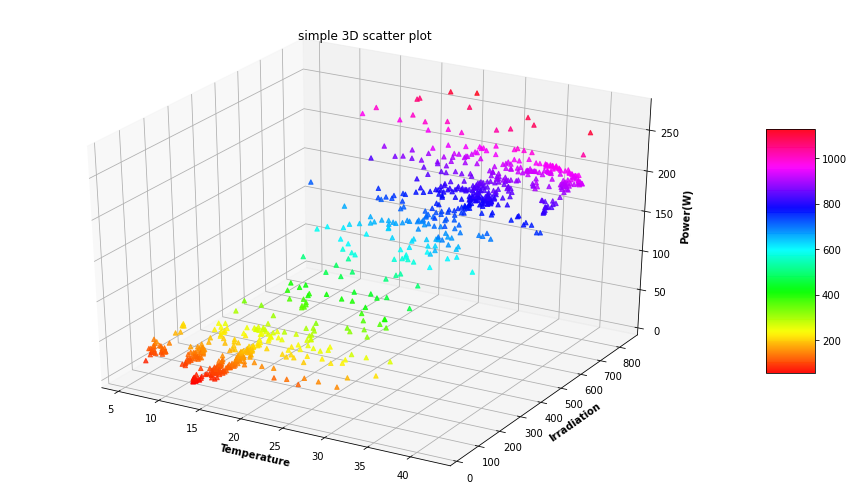

In [5]:
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
x=df['T']
y=df['G']
z=df['Pmax']
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("simple 3D scatter plot")
ax.set_xlabel('Temperature', fontweight ='bold')
ax.set_ylabel('Irradiation', fontweight ='bold')
ax.set_zlabel('Power(W)', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()



# 2D
# df.plot(x ='Vmax', y='Pmax', kind = 'scatter')	
# df.plot(x ='Vmax', y='Imax', kind = 'scatter')	

# 3D without color
# threedee = plt.figure(figsize = (12, 8)).gca(projection='3d')
# threedee.scatter(df['T'], df['G'], df['Pmax'])
# threedee.set_xlabel('Temperature')
# threedee.set_ylabel('Irradiation')
# threedee.set_zlabel('Power(W)')
# plt.show()

#converting spark dataframe to pandas dataframe aiming to use matplotlib
# pdf = sdf.toPandas()

##Loading data into a Spark DataFrame

In [6]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Initialize Spark session
spark

# We use the `createDataFrame` function to load the data into a spark dataframe
sdf = spark.createDataFrame(df)

# Let us look at the schema of the loaded spark dataframe
sdf.printSchema()

root
 |-- Pmax: double (nullable = true)
 |-- Vmax: double (nullable = true)
 |-- Imax: double (nullable = true)
 |-- G: double (nullable = true)
 |-- T: double (nullable = true)



##Converting data frame columns into feature vectors

In [22]:
assembler1 = VectorAssembler(
    inputCols=["T", "G"],
    outputCol="features1")

assembler2 = VectorAssembler(
    inputCols=["T", "Pmax"],
    outputCol="features2")

assembler3 = VectorAssembler(
    inputCols=["G", "Pmax"],
    outputCol="features3")

# Output voltage
output1 = assembler1.transform(sdf).select('features1','Vmax')
output2 = assembler2.transform(sdf).select('features2','Vmax')
output3 = assembler3.transform(sdf).select('features3','Vmax')

# Output Current
output4 = assembler1.transform(sdf).select('features1','Imax')
output5 = assembler2.transform(sdf).select('features2','Imax')
output6 = assembler3.transform(sdf).select('features3','Imax')


train1, test1 = output1.randomSplit([0.75, 0.25])
train2, test2 = output2.randomSplit([0.75, 0.25])
train3, test3 = output3.randomSplit([0.75, 0.25])
train4, test4 = output4.randomSplit([0.75, 0.25])
train5, test5 = output5.randomSplit([0.75, 0.25])
train6, test6 = output6.randomSplit([0.75, 0.25])

#stats

##1) Correlation
##### Correlation means to find out the association between the two variables and Correlation coefficients are used to find out how strong is the relationship between the two variables.

### a) *Pearson* correlation

In [25]:
corr1 = Correlation.corr(train1, "features1", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr1[0]))

corr2 = Correlation.corr(train2, "features2", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr2[0]))

corr3 = Correlation.corr(train3, "features3", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr3[0]))

corr4 = Correlation.corr(train4, "features1", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr4[0]))

corr5 = Correlation.corr(train5, "features2", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr5[0]))

corr6 = Correlation.corr(train6, "features3", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr6[0]))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Pearson correlation matrix:
DenseMatrix([[1.       , 0.8604508],
             [0.8604508, 1.       ]])
Pearson correlation matrix:
DenseMatrix([[1.       , 0.8546965],
             [0.8546965, 1.       ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.99769356],
             [0.99769356, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.       , 0.8579717],
             [0.8579717, 1.       ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.84436754],
             [0.84436754, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.99757033],
             [0.99757033, 1.        ]])


### b) *Spearman* correlation

In [15]:
corr2 = Correlation.corr(train, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(corr2[0]))

Spearman correlation matrix:
DenseMatrix([[1.       , 0.8505731],
             [0.8505731, 1.       ]])


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning
